In [1]:
import matplotlib.pyplot as plt                 # For normal plotting
from mpl_toolkits.mplot3d import proj3d         # For 3D plotting
import numpy as np                              # For maths
from scipy import ndimage                       # For image rotations
import astra                                    # For tomography framework
import copy                                     # For deep copying arrays

import multi_axis                               # My custom functions

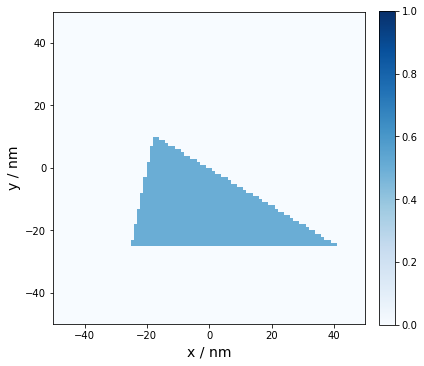

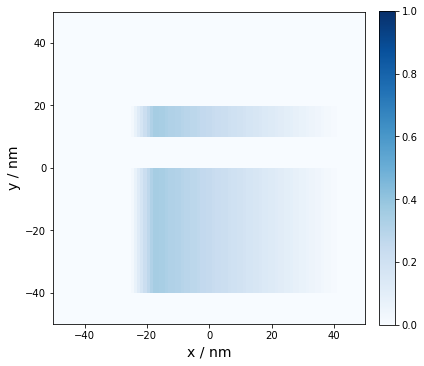

In [2]:
# Generate phantom
X,Y,Z,P = multi_axis.generate_tri_pris()

# View in 2D
multi_axis.plot_2d(X,Y,Z,P)

# Rotate 90 about +x and view again
Pr = multi_axis.rotate_bulk(P,90,0,0)
multi_axis.plot_2d(X,Y,Z,Pr)

In [29]:
# Create tilt series about x
ax,ay,az = 0,0,0

P_projs = []
vectors = []
thetas = []
for ax in np.linspace(-70,70,10):
    vector = multi_axis.get_astravec(ax,ay,az)
    vector[0:3] = np.array(multi_axis.rotation_matrix(ax,ay,az)).dot([0,0,1])
    thetas.append(ax*np.pi/180)
    vectors.append(vector)
    P_rot = multi_axis.rotate_bulk(P,ax,ay,az)
    P_rot_proj =np.flipud(np.mean(P_rot,axis=2).T)
    P_projs.append(P_rot_proj)
    
raw_data = P_projs
np.shape(raw_data)

(10, 100, 100)

In [30]:
# Prepare projections for reconstruction
raw_data = np.array(raw_data)
raw_data = raw_data -  raw_data.min()
raw_data = raw_data/raw_data.max()
raw_data = np.transpose(raw_data,axes=[1,0,2]) # reshape so z is middle column
np.shape(raw_data)

(100, 10, 100)

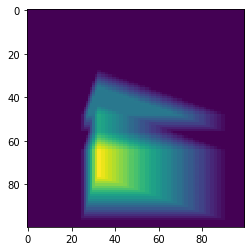

In [31]:
plt.imshow(raw_data[:,8,:])

In [21]:
vectors = np.zeros((10,12))

for i in range(10):
    a = theta[i]
    vectors[i,0:3] = [np.sin(a),0,-np.cos(a)] # ray direction r
    vectors[i,3:6] = [0,0,0] # centre of detector
    vectors[i,6:9] = [np.cos(a),0,np.sin(a)] # u (det +y)
    vectors[i,9:12] = [0,1,0] # v (det +x)
    
proj_geom = astra.create_proj_geom('parallel3d_vec',100,100,vectors)

In [11]:
def get_astravec(ax,ay,az):
    """ Given angles in degrees, return r,d,u,v as a concatenation
    of four 3-component vectors"""
    # ray direction r
    r = np.array(multi_axis.angle_to_vector(ax,ay,az))*-1
    # centre of detector
    d = [0,0,0]
    
    # 3D rotation matrix
    mrot = np.array(multi_axis.rotation_matrix(ax,ay,az))
    # u (det +x)
    u = mrot.dot([1,0,0])
    # v (det +y)
    v = mrot.dot([0,1,0])

    return np.concatenate((r,d,u,v))

get_astravec(-70,0,0)

array([-0.        , -0.93969262, -0.34202014,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.34202014, -0.93969262])

In [50]:
for i in range(10):
    a = theta[i] * 180/np.pi
    v = multi_axis.angle_to_vector(a,0,0)
    mrot = rotation_matrix(a,0,0)
    xr = mrot.dot([1,0,0])
    yr = mrot.dot([0,1,0])
    print(np.round(v,decimals=1),xr,np.round(yr,decimals=1))

[ 0.   0.9  0.3] [ 1.  0.  0.] [ 0.   0.3 -0.9]
[ 0.   0.8  0.6] [ 1.  0.  0.] [ 0.   0.6 -0.8]
[ 0.   0.6  0.8] [ 1.  0.  0.] [ 0.   0.8 -0.6]
[ 0.   0.4  0.9] [ 1.  0.  0.] [ 0.   0.9 -0.4]
[ 0.   0.1  1. ] [ 1.  0.  0.] [ 0.   1.  -0.1]
[-0.  -0.1  1. ] [ 1.  0.  0.] [ 0.   1.   0.1]
[-0.  -0.4  0.9] [ 1.  0.  0.] [ 0.   0.9  0.4]
[-0.  -0.6  0.8] [ 1.  0.  0.] [ 0.   0.8  0.6]
[-0.  -0.8  0.6] [ 1.  0.  0.] [ 0.   0.6  0.8]
[-0.  -0.9  0.3] [ 1.  0.  0.] [ 0.   0.3  0.9]


In [48]:
def rotation_matrix(ax,ay,az):
    """ 
    Generate 3D rotation matrix from rotation angles ax,ay,az 
    about the x,y,z axes (given in degrees) 
    (Uses convention of rotating about z, then y, then x)
    """

    ax = ax * np.pi/180
    Cx = np.cos(ax)
    Sx = np.sin(ax)
    mrotx = np.array([[1,0,0],[0,Cx,-Sx],[0,Sx,Cx]])
    
    ay = ay * np.pi/180
    Cy = np.cos(ay)
    Sy = np.sin(ay)
    mroty = np.array([[Cy,0,Sy],[0,1,0],[-Sy,0,Cy]])
    
    az = az * np.pi/180
    Cz = np.cos(az)
    Sz = np.sin(az)
    mrotz = np.array([[Cz,-Sz,0],[Sz,Cz,0],[0,0,1]])
    
    mrot = mrotz.dot(mroty).dot(mrotx)
    
    return mrot

In [6]:
vol_geom = astra.create_vol_geom(raw_data.shape[0],raw_data.shape[1],raw_data.shape[2])

proj_id = astra.data3d.create('-proj3d',proj_geom,raw_data)

vol_id = astra.data3d.create('-vol',vol_geom,0)

In [32]:
proj_geom = astra.create_proj_geom('parallel3d_vec',100,100,np.array(vectors))
projections_id = astra.data3d.create('-sino', proj_geom, raw_data)
# proj_geom = astra.create_proj_geom('parallel3d',1,1,100,100,np.array(thetas))
# projections_id = astra.data3d.create('-sino', proj_geom, np.transpose(raw_data,axes=[2,1,0]))
vol_geom = astra.creators.create_vol_geom(100, 100,
                                          100)
reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
alg_cfg = astra.astra_dict('SIRT3D_CUDA')
alg_cfg['ProjectionDataId'] = projections_id
alg_cfg['ReconstructionDataId'] = reconstruction_id
algorithm_id = astra.algorithm.create(alg_cfg)

In [33]:
astra.algorithm.run(algorithm_id,iterations=10)
reconstruction = astra.data3d.get(reconstruction_id)
np.shape(reconstruction)

(100, 100, 100)

In [12]:
reconstruction = np.transpose(reconstruction,[1,2,0])

In [92]:
alg_cfg = astra.astra_dict('SIRT3D_CUDA')
alg_cfg['ProjectionDataID'] = proj_id
alg_cfg['ReconstructionDataId'] = vol_id
#alg_id = astra.algorithm.create(alg_cfg)
astra.algorithm.create(alg_cfg)

# alg_cfg = astra.astra_dict('SIRT3D_CUDA')
# alg_id = astra.algorithm.create(alg_cfg)

NameError: name 'proj_id' is not defined

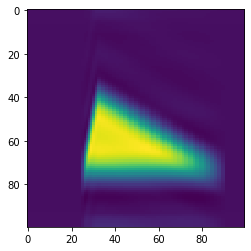

In [37]:
plt.imshow(np.mean(recon_vector,axis=0))

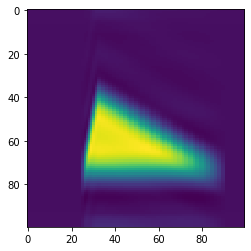

In [14]:
plt.imshow(np.mean(recon_normal,axis=0))

In [13]:
recon_normal = copy.deepcopy(reconstruction)
#recon_vector = copy.deepcopy(reconstruction)

In [38]:
np.sum(recon_vector-recon_normal)

-5.5531316e-05

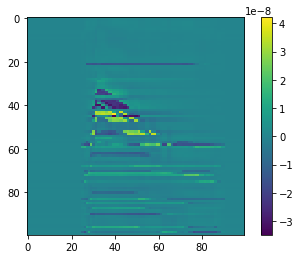

In [41]:
a = recon_normal-recon_vector
plt.imshow(np.mean(a,axis=0))
plt.colorbar()

In [8]:
# Create synthetic dataset
from __future__ import division
 
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import get_writer
 
import astra
 
# Configuration.
distance_source_origin = 300  # [mm]
distance_origin_detector = 100  # [mm]
detector_pixel_size = 1.05  # [mm]
detector_rows = 200  # Vertical size of detector [pixels].
detector_cols = 200  # Horizontal size of detector [pixels].
num_of_projections = 180
angles = np.linspace(0, 2 * np.pi, num=num_of_projections, endpoint=False)
output_dir = 'dataset'
 
# Create phantom.
vol_geom = astra.creators.create_vol_geom(detector_cols, detector_cols,
                                          detector_rows)
phantom = np.zeros((detector_rows, detector_cols, detector_cols))
hb = 110  # Height of beam [pixels].
wb = 40   # Width of beam [pixels].
hc = 100  # Height of cavity in beam [pixels].
wc = 30   # Width of cavity in beam [pixels].
phantom[detector_rows // 2 - hb // 2 : detector_rows // 2 + hb // 2,
        detector_cols // 2 - wb // 2 : detector_cols // 2 + wb // 2,
        detector_cols // 2 - wb // 2 : detector_cols // 2 + wb // 2] = 1
phantom[detector_rows // 2 - hc // 2 : detector_rows // 2 + hc // 2,
        detector_cols // 2 - wc // 2 : detector_cols // 2 + wc // 2,
        detector_cols // 2 - wc // 2 : detector_cols // 2 + wc // 2] = 0
phantom[detector_rows // 2 - 5 :       detector_rows // 2 + 5,
        detector_cols // 2 + wc // 2 : detector_cols // 2 + wb // 2,
        detector_cols // 2 - 5 :       detector_cols // 2 + 5] = 0
phantom_id = astra.data3d.create('-vol', vol_geom, data=phantom)
 
# Create projections. With increasing angles, the projection are such that the
# object is rotated clockwise. Slice zero is at the top of the object. The
# projection from angle zero looks upwards from the bottom of the slice.
proj_geom = \
  astra.create_proj_geom('cone', 1, 1, detector_rows, detector_cols, angles,
                         (distance_source_origin + distance_origin_detector) /
                         detector_pixel_size, 0)
projections_id, projections = \
  astra.creators.create_sino3d_gpu(phantom_id, proj_geom, vol_geom)
projections /= np.max(projections)
 
# Apply Poisson noise.
projections = np.random.poisson(projections * 10000) / 10000
projections[projections > 1.1] = 1.1
projections /= 1.1
 
# Save projections.
if not isdir(output_dir):
    mkdir(output_dir)
projections = np.round(projections * 65535).astype(np.uint16)
for i in range(num_of_projections):
    projection = projections[:, i, :]
    with get_writer(join(output_dir, 'proj%04d.tif' %i)) as writer:
        writer.append_data(projection, {'compress': 9})
 


# Cleanup.
astra.data3d.delete(projections_id)
astra.data3d.delete(phantom_id)


In [28]:
np.shape(projections)

(200, 180, 200)

In [9]:
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import imread, imwrite
 
import astra
 
# Configuration.
distance_source_origin = 300  # [mm]
distance_origin_detector = 100  # [mm]
detector_pixel_size = 1.05  # [mm]
detector_rows = 200  # Vertical size of detector [pixels].
detector_cols = 200  # Horizontal size of detector [pixels].
num_of_projections = 180
angles = np.linspace(0, 2 * np.pi, num=num_of_projections, endpoint=False)
input_dir = 'dataset'
output_dir = 'reconstruction'
 
# Load projections.
projections = np.zeros((detector_rows, num_of_projections, detector_cols))
for i in range(num_of_projections):
    im = imread(join(input_dir, 'proj%04d.tif' % i)).astype(float)
    im /= 65535
    projections[:, i, :] = im
 
# Copy projection images into ASTRA Toolbox.
proj_geom = \
  astra.create_proj_geom('cone', 1, 1, detector_rows, detector_cols, angles,
                         (distance_source_origin + distance_origin_detector) /
                         detector_pixel_size, 0)
projections_id = astra.data3d.create('-sino', proj_geom, projections)
 
# Create reconstruction.
vol_geom = astra.creators.create_vol_geom(detector_cols, detector_cols,
                                          detector_rows)
reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
alg_cfg = astra.astra_dict('FDK_CUDA')
alg_cfg['ProjectionDataId'] = projections_id
alg_cfg['ReconstructionDataId'] = reconstruction_id
algorithm_id = astra.algorithm.create(alg_cfg)
astra.algorithm.run(algorithm_id)
reconstruction = astra.data3d.get(reconstruction_id)
 
# Limit and scale reconstruction.
reconstruction[reconstruction < 0] = 0
reconstruction /= np.max(reconstruction)
reconstruction = np.round(reconstruction * 255).astype(np.uint8)
 
# Save reconstruction.
if not isdir(output_dir):
    mkdir(output_dir)
for i in range(detector_rows):
    im = reconstruction[i, :, :]
    im = np.flipud(im)
    imwrite(join(output_dir, 'reco%04d.png' % i), im)
 
# Cleanup.
astra.algorithm.delete(algorithm_id)
astra.data3d.delete(reconstruction_id)
astra.data3d.delete(projections_id)

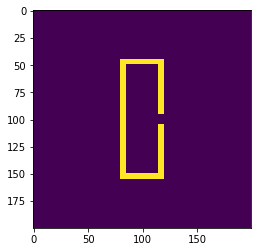

In [15]:
plt.imshow(phantom[:,:,100])

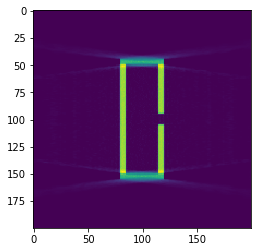

In [14]:
plt.imshow(reconstruction[:,:,100])

In [27]:
ax,ay,az=90,0,0
a = np.array(multi_axis.rotation_matrix(ax,ay,az)).dot([0,0,1])
b = multi_axis.angle_to_vector(ax,ay,az)
print(np.round(a,decimals=1),np.round(b,decimals=1))

[ 0. -1.  0.] [-0. -1.  0.]
